In [1]:
from tqdm.auto import tqdm
import multiprocessing
import sys
from datetime import datetime
from time import sleep
import datetime as dt
import pandas as pd

from Pandora.helper import TDays
from Pandora.research.backtest import CODES_SHORT, calc_sharpe, COMMISSION, CODES_TRADABLE_SL
from vnpy.app.vnpy_portfoliostrategy.strategies.macd_bband_strategy import MACDBBANDStrategy
from vnpy.trader.constant import Interval, Product
from vnpy.trader.optimize import OptimizationSetting
from vnpy.trader.setting import SETTINGS
from logging import INFO
from vnpy.app.vnpy_portfoliostrategy import BacktestingEngine

SETTINGS["log.active"] = True
SETTINGS["log.level"] = INFO
SETTINGS["log.console"] = True



In [2]:
def get_mc(codes):
    from vnpy.trader.database import get_database

    database = get_database()
    today = datetime.combine(TDays.get_tday(fmt=None), dt.time(0))
    contracts = database.load_contract_data(product=Product.FUTURES, start=today, end=today)
    mc = [i for i in contracts if i.symbol.endswith('00') and i.product_id in codes]

    return mc


In [7]:
mc = get_mc(CODES_SHORT | {'lc', 'ec', 'si', 'ao'})


In [8]:
engine = BacktestingEngine()
engine.contracts = {i.vt_symbol: i for i in mc}

engine.set_parameters(
    vt_symbols=[i.vt_symbol for i in mc],
    interval=Interval.MINUTE_15,
    start=datetime(2015, 1, 1),
    end=datetime(2024, 8, 16),
    rates={
        i.vt_symbol: COMMISSION for i in mc
    },
    slippages={
        i.vt_symbol: 0 for i in mc
    },
    sizes={
        i.vt_symbol: i.size for i in mc
    },
    priceticks={
        i.vt_symbol: i.pricetick for i in mc
    },
    capital=1e8,
)

engine.load_data()



2024-08-21 16:08:46.321754	开始加载历史数据
2024-08-21 16:08:46.329732	AP00.CZCE历史数据加载完成，数据量：24195
2024-08-21 16:08:46.336714	CJ00.CZCE历史数据加载完成，数据量：19290
2024-08-21 16:08:46.358655	FG00.CZCE历史数据加载完成，数据量：54122
2024-08-21 16:08:46.378601	MA00.CZCE历史数据加载完成，数据量：55152
2024-08-21 16:08:46.387577	PF00.CZCE历史数据加载完成，数据量：21336
2024-08-21 16:08:46.396553	PK00.CZCE历史数据加载完成，数据量：12855
2024-08-21 16:08:46.407524	SA00.CZCE历史数据加载完成，数据量：25452
2024-08-21 16:08:46.430462	TA00.CZCE历史数据加载完成，数据量：55152
2024-08-21 16:08:46.436446	UR00.CZCE历史数据加载完成，数据量：18255
2024-08-21 16:08:46.479332	ag00.SHFE历史数据加载完成，数据量：83799
2024-08-21 16:08:46.505262	al00.SHFE历史数据加载完成，数据量：70521
2024-08-21 16:08:46.767561	ao00.SHFE历史数据加载完成，数据量：8058
2024-08-21 16:08:46.798478	cu00.SHFE历史数据加载完成，数据量：70521
2024-08-21 16:08:46.809448	eb00.DCE历史数据加载完成，数据量：26496
2024-08-21 16:08:46.848344	ec00.INE历史数据加载完成，数据量：3540
2024-08-21 16:08:46.861310	eg00.DCE历史数据加载完成，数据量：30373
2024-08-21 16:08:46.886243	hc00.SHFE历史数据加载完成，数据量：55308
2024-08-21 16:08:46.912174	i00.DCE

2024-08-21 16:29:11.043465	策略初始化完成
2024-08-21 16:29:11.044463	开始回放历史数据


回放历史数据:   0%|          | 0/79805 [00:00<?, ?it/s]

2024-08-21 16:30:33.885918	历史数据回放结束
2024-08-21 16:30:33.886916	开始计算逐日盯市盈亏
2024-08-21 16:30:33.985651	逐日盯市盈亏计算完成


1.6708905781916017

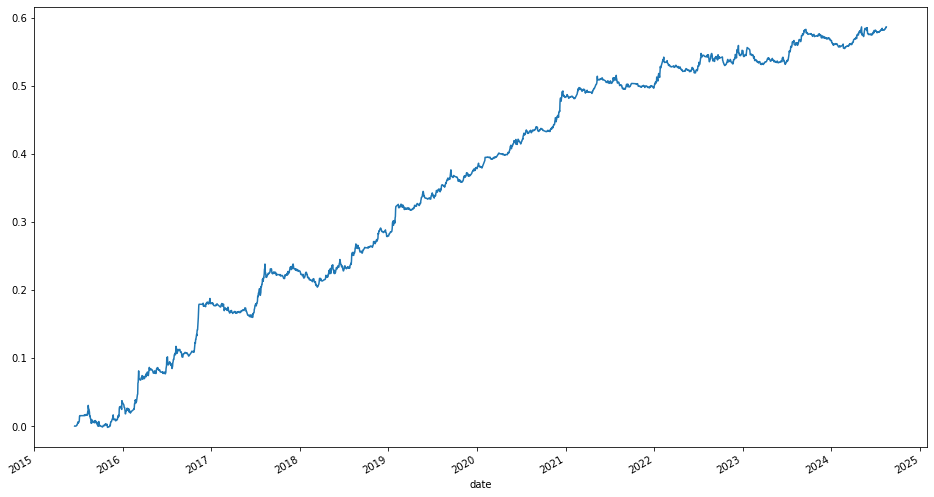

In [14]:
engine.clear_data()
setting = {
    "window": 350,
    "bband_width": 1.5,
}
engine.add_strategy(MACDBBANDStrategy, setting)

engine.run_backtesting()
df = engine.calculate_result()

daily_base = pd.Series(df['net_pnl'] / engine.capital, index=pd.to_datetime(df.index))
daily_base.cumsum().plot(figsize=(16, 9))
calc_sharpe(daily_base)

In [6]:
desc, rounds = engine.describe_trades()
rounds

,symbol,direction,open_time,open_price,close_time,close_price,volume,pnl,hp
0,AP00,Direction.LONG,2018-06-08 14:00:00+08:00,8885.813828,2018-06-19 09:15:00+08:00,10344.694001,16,0.164181,10.802083
1,AP00,Direction.SHORT,2018-07-05 14:15:00+08:00,9555.614159,2018-07-19 09:30:00+08:00,9482.0,14,0.007704,13.802083
2,AP00,Direction.SHORT,2018-10-09 14:30:00+08:00,10998.514315,2018-10-26 21:00:00+08:00,10444.746897,10,0.050349,17.270833
3,AP00,Direction.SHORT,2018-11-19 11:00:00+08:00,10765.0,2018-12-07 13:45:00+08:00,10269.0,18,0.046075,18.114583
4,AP00,Direction.LONG,2019-02-18 11:15:00+08:00,9734.0,2019-03-04 09:15:00+08:00,9450.146596,20,-0.029161,13.916667
...,...,...,...,...,...,...,...,...,...
79,zn00,Direction.LONG,2024-02-01 09:45:00+08:00,23145.0,2024-02-05 23:00:00+08:00,22650.0,14,-0.021387,4.552083
80,zn00,Direction.SHORT,2024-02-08 14:45:00+08:00,22626.265874,2024-02-26 14:00:00+08:00,22635.0,15,-0.000386,17.96875
81,zn00,Direction.LONG,2024-03-14 11:15:00+08:00,23779.934956,2024-03-26 14:30:00+08:00,23235.0,14,-0.022916,12.135417
82,zn00,Direction.LONG,2024-04-11 09:45:00+08:00,25026.664881,2024-04-15 21:15:00+08:00,25015.630197,9,-0.000441,4.479167


In [7]:
from vnpy.trader.constant import Direction

def rounds_to_open_signal(rounds):
    open_signal = pd.DataFrame()
    
    for i in range(len(rounds)):
        symbol = rounds['symbol'].iat[i]
        direction = rounds['direction'].iat[i]
        open_time = rounds['open_time'].iat[i]
        close_time = rounds['close_time'].iat[i]
        
        if direction == Direction.LONG:
            open_signal.loc[open_time, symbol] = 1
        else:
            open_signal.loc[open_time, symbol] = -1
    
        open_signal.loc[close_time, symbol] = 0
    
    open_signal.index = open_signal.index.tz_localize(None)
    open_signal = open_signal.sort_index()
    
    return open_signal

In [8]:
from Pandora.constant import Frequency
from Pandora.research import *

codes = CODES_TRADABLE_SL
quote_bt, ret = get_quote(codes, end=dt.datetime.now(), freq=Frequency.Min_15)
weight = get_weight_by_std_minus(quote_bt, 100, n=3)


1.2248490123178744

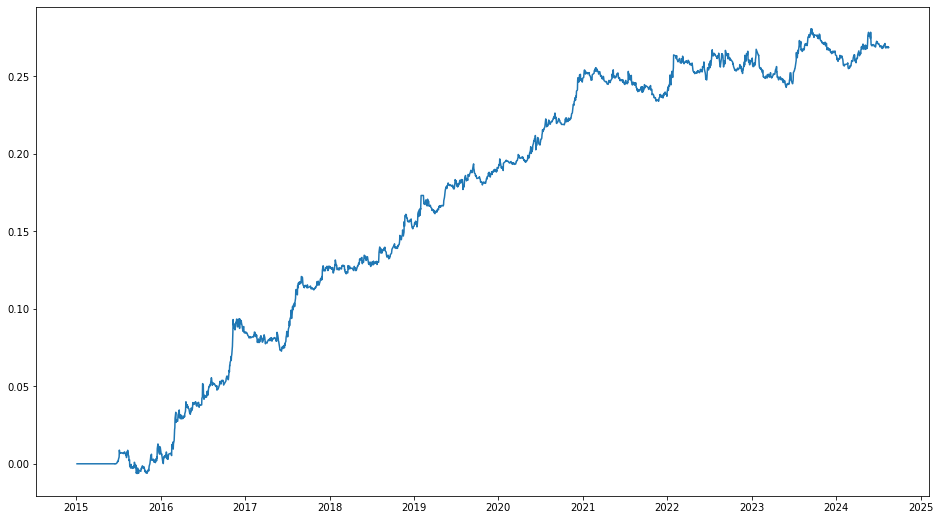

In [9]:
weight = weight.loc[:datetime(2024, 8, 16), :]
ret = ret.loc[:datetime(2024, 8, 16), :]
open_signal = rounds_to_open_signal(rounds)
_, open_signal = ret.align(open_signal, join='left')
daily_base = backtest_factor(open_signal, weight, ret, COMMISSION)

daily_base.cumsum().plot(figsize=(16, 9))
calc_sharpe(daily_base)

## Full set

- CODES_SHORT
- Vol exit
- LS imba

### ATR multiplier = 11

In [9]:
setting = {
    "window": 50,
}
engine.add_strategy(MACDBBANDStrategy, setting)


setting = OptimizationSetting()
setting.set_target("sharpe_ratio")
setting.add_parameter("window", 50, 500, 50)
setting.add_parameter("bband_width", 1.5, 2, 0.25)
setting.add_parameter("atr_multiplier", 11)

opt_res = engine.run_bf_optimization(setting, max_workers=3)

2024-08-21 16:09:19.930699	开始执行穷举算法优化
2024-08-21 16:09:19.930699	参数优化空间：30


100%|██████████| 30/30 [16:24<00:00, 32.82s/it]


2024-08-21 16:25:48.203568	穷举算法优化完成，耗时988秒
2024-08-21 16:25:50.339504	参数：{'window': 350, 'bband_width': 1.5, 'atr_multiplier': 11}, 目标：1.6482621160456545
2024-08-21 16:25:50.339504	参数：{'window': 250, 'bband_width': 1.5, 'atr_multiplier': 11}, 目标：1.4280415876905517
2024-08-21 16:25:50.339504	参数：{'window': 50, 'bband_width': 1.5, 'atr_multiplier': 11}, 目标：1.4257912029394062
2024-08-21 16:25:50.339504	参数：{'window': 200, 'bband_width': 2.0, 'atr_multiplier': 11}, 目标：1.4020287389747028
2024-08-21 16:25:50.339504	参数：{'window': 450, 'bband_width': 1.75, 'atr_multiplier': 11}, 目标：1.395863619573767
2024-08-21 16:25:50.339504	参数：{'window': 400, 'bband_width': 1.75, 'atr_multiplier': 11}, 目标：1.3672297791824217
2024-08-21 16:25:50.339504	参数：{'window': 350, 'bband_width': 1.75, 'atr_multiplier': 11}, 目标：1.3522072720706593
2024-08-21 16:25:50.339504	参数：{'window': 350, 'bband_width': 2.0, 'atr_multiplier': 11}, 目标：1.3492731442376498
2024-08-21 16:25:50.339504	参数：{'window': 200, 'bband_width': 1.75, '

In [11]:
for res in opt_res:
    rounds = res[3]
    open_signal = rounds_to_open_signal(rounds)
    
    params = '_'.join((str(k) + "_" + str(v) for k, v in res[0].items()))
    strategy_id = f"MACDBBANDStrategy_{params}"
    open_signal.to_parquet(strategy_id + ".parquet")

In [13]:
sharpe_mat = pd.DataFrame()

for res in opt_res:
    param = res[0]
    sharpe = res[1]
    
    sharpe_mat.loc[param['window'], param['bband_width']] = sharpe
    
sharpe_mat.sort_index().iloc[:, [0, 2, 1]]


,1.50,1.75,2.00
50,1.425791,1.247077,1.171932
100,1.265584,1.094706,0.971590
150,1.177226,1.271413,1.127796
200,1.225514,1.342399,1.402029
250,1.428042,1.242808,1.310535
300,1.172881,1.238992,1.233289
350,1.648262,1.352207,1.349273
400,1.339767,1.367230,1.166489
450,1.282190,1.395864,1.045217
500,1.130448,1.217158,1.180050


### ATR multiplier = 13

In [10]:
setting = {
    "window": 50,
}
engine.add_strategy(MACDBBANDStrategy, setting)


setting = OptimizationSetting()
setting.set_target("sharpe_ratio")
setting.add_parameter("window", 50, 500, 50)
setting.add_parameter("bband_width", 1.5, 2, 0.25)
setting.add_parameter("atr_multiplier", 13)

opt_res = engine.run_bf_optimization(setting, max_workers=5)

sharpe_mat = pd.DataFrame()

for res in opt_res:
    param = res[0]
    sharpe = res[1]

    sharpe_mat.loc[param['window'], param['bband_width']] = sharpe

sharpe_mat.sort_index()

2024-08-21 10:02:08.126193	开始执行穷举算法优化
2024-08-21 10:02:08.126193	参数优化空间：30


100%|██████████| 30/30 [30:15<00:00, 60.51s/it]  


2024-08-21 10:32:29.213541	穷举算法优化完成，耗时1821秒
2024-08-21 10:32:37.202160	参数：{'window': 450, 'bband_width': 1.75, 'atr_multiplier': 13}, 目标：1.2101463176244218
2024-08-21 10:32:37.203157	参数：{'window': 100, 'bband_width': 1.5, 'atr_multiplier': 13}, 目标：1.2014774100057335
2024-08-21 10:32:37.203157	参数：{'window': 200, 'bband_width': 2.0, 'atr_multiplier': 13}, 目标：1.1611758432886177
2024-08-21 10:32:37.203157	参数：{'window': 350, 'bband_width': 1.5, 'atr_multiplier': 13}, 目标：1.1531206290408385
2024-08-21 10:32:37.203157	参数：{'window': 300, 'bband_width': 1.75, 'atr_multiplier': 13}, 目标：1.1504341043468622
2024-08-21 10:32:37.203157	参数：{'window': 250, 'bband_width': 1.75, 'atr_multiplier': 13}, 目标：1.1285729533115862
2024-08-21 10:32:37.203157	参数：{'window': 200, 'bband_width': 1.75, 'atr_multiplier': 13}, 目标：1.1022708051497283
2024-08-21 10:32:37.203157	参数：{'window': 400, 'bband_width': 1.75, 'atr_multiplier': 13}, 目标：1.0928913589706717
2024-08-21 10:32:37.204155	参数：{'window': 150, 'bband_width': 2.

,1.75,1.50,2.00
50,1.020489,1.052902,0.989047
100,1.038769,1.201477,0.919784
150,1.075508,1.036778,1.084615
200,1.102271,1.005955,1.161176
250,1.128573,1.033601,0.983525
300,1.150434,0.954937,0.989781
350,1.021004,1.153121,1.065890
400,1.092891,1.016203,1.005850
450,1.210146,1.061239,0.821743
500,0.787077,1.012448,1.003344


In [11]:
for res in opt_res:
    rounds = res[3]
    open_signal = rounds_to_open_signal(rounds)
    
    params = '_'.join((str(k) + "_" + str(v) for k, v in res[0].items()))
    strategy_id = f"MACDBBANDStrategy_{params}"
    open_signal.to_parquet(strategy_id + ".parquet")

## LS balance

In [ ]:
setting = {
    "window": 50,
}
engine.add_strategy(MACDBBANDStrategy, setting)


setting = OptimizationSetting()
setting.set_target("sharpe_ratio")
setting.add_parameter("window", 50, 500, 50)
setting.add_parameter("bband_width", 1.5, 2, 0.25)
setting.add_parameter("atr_multiplier", 13)
setting.add_parameter("ls_imba", 1)

opt_res = engine.run_bf_optimization(setting, max_workers=10)

sharpe_mat = pd.DataFrame()

for res in opt_res:
    param = res[0]
    sharpe = res[1]

    sharpe_mat.loc[param['window'], param['bband_width']] = sharpe

sharpe_mat.sort_index()

## CODES_MM

In [ ]:
from Pandora.research import CODES_MM

mc = get_mc(CODES_MM)


In [ ]:
engine = BacktestingEngine()
engine.contracts = {i.vt_symbol: i for i in mc}

engine.set_parameters(
    vt_symbols=[i.vt_symbol for i in mc],
    interval=Interval.MINUTE_15,
    start=datetime(2015, 1, 1),
    end=datetime(2024, 6, 27),
    rates={
        i.vt_symbol: COMMISSION for i in mc
    },
    slippages={
        i.vt_symbol: 0 for i in mc
    },
    sizes={
        i.vt_symbol: i.size for i in mc
    },
    priceticks={
        i.vt_symbol: i.pricetick for i in mc
    },
    capital=1e8,
)

engine.load_data()



In [ ]:
setting = {
    "window": 50,
}
engine.add_strategy(MACDBBANDStrategy, setting)


setting = OptimizationSetting()
setting.set_target("sharpe_ratio")
setting.add_parameter("window", 50, 500, 50)
setting.add_parameter("bband_width", 1.5, 2, 0.25)
setting.add_parameter("atr_multiplier", 11)

opt_res = engine.run_bf_optimization(setting, max_workers=8)

In [ ]:
sharpe_mat = pd.DataFrame()

for res in opt_res:
    param = res[0]
    sharpe = res[1]
    
    sharpe_mat.loc[param['window'], param['bband_width']] = sharpe
    
sharpe_mat
